# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [50]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   book        1206 non-null   object
 1   perception  1206 non-null   int64 
 2   int         1206 non-null   int64 
 3   level       1206 non-null   int64 
 4   dex         1206 non-null   int64 
 5   wis         1206 non-null   int64 
 6   ac          1206 non-null   int64 
 7   hp          1206 non-null   int64 
 8   will        1206 non-null   int64 
 9   str         1206 non-null   int64 
 10  fortitude   1206 non-null   int64 
 11  con         1206 non-null   int64 
 12  cha         1206 non-null   int64 
 13  reflex      1206 non-null   int64 
 14  focus       1206 non-null   int32 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [52]:
df.head()

,book,perception,int,level,dex,wis,ac,hp,will,str,fortitude,con,cha,reflex,focus
0,Pathfinder Bestiary,20,1,10,2,2,29,215,17,7,22,5,1,19,1
1,Pathfinder Bestiary,16,-4,10,0,2,28,220,16,9,21,5,1,14,0
2,Pathfinder Bestiary,17,-4,8,3,3,25,175,15,7,20,6,-2,17,0
3,Pathfinder Bestiary,30,6,17,4,5,41,315,32,7,30,5,6,29,1
4,Pathfinder Bestiary,6,-1,1,3,1,16,20,4,-5,6,1,1,10,1


###### Level

In [53]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [54]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [55]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


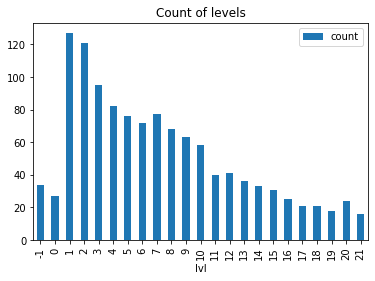

In [56]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [57]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [58]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [59]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [60]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [61]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [62]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.26
RMSE: 0.51
MAE: 0.36


In [64]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [65]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

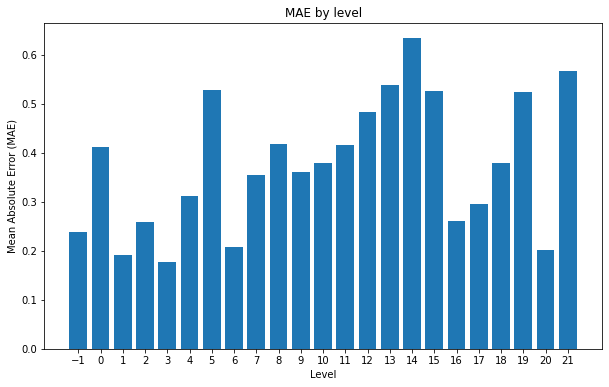

In [66]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [67]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.29
RMSE: 0.54



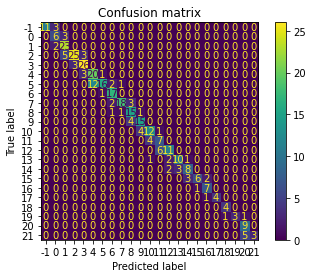

In [68]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [69]:
from training.results import assess_regression_model

In [70]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 22:48:47,225] A new study created in memory with name: no-name-7e0077b6-5c16-4b80-b2cf-2c4fc47e828a
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.180752 + 0.0352041
[200]	cv_agg's l2: 0.177997 + 0.0347951


feature_fraction, val_score: 0.177755:   0%|                                                     | 0/7 [00:01<?, ?it/s]

[300]	cv_agg's l2: 0.178515 + 0.034813
Early stopping, best iteration is:
[253]	cv_agg's l2: 0.177755 + 0.0345625


feature_fraction, val_score: 0.177755:  14%|######4                                      | 1/7 [00:01<00:07,  1.21s/it]

[100]	cv_agg's l2: 0.187674 + 0.0414439
[200]	cv_agg's l2: 0.174675 + 0.038664
[300]	cv_agg's l2: 0.172386 + 0.0385788
[400]	cv_agg's l2: 0.171852 + 0.038504


feature_fraction, val_score: 0.171437:  29%|############8                                | 2/7 [00:03<00:08,  1.67s/it]

[500]	cv_agg's l2: 0.171581 + 0.0388527
Early stopping, best iteration is:
[430]	cv_agg's l2: 0.171437 + 0.038611
[100]	cv_agg's l2: 0.181551 + 0.0361725
[200]	cv_agg's l2: 0.177664 + 0.0340817
[300]	cv_agg's l2: 0.177649 + 0.0341529
[400]	cv_agg's l2: 0.178297 + 0.0347854


feature_fraction, val_score: 0.171437:  43%|###################2                         | 3/7 [00:05<00:07,  1.85s/it]

[500]	cv_agg's l2: 0.179363 + 0.034597
Early stopping, best iteration is:
[430]	cv_agg's l2: 0.171437 + 0.038611
[100]	cv_agg's l2: 0.18845 + 0.0390648
[200]	cv_agg's l2: 0.185927 + 0.0365929
[300]	cv_agg's l2: 0.185499 + 0.0361031
[400]	cv_agg's l2: 0.186808 + 0.036314


feature_fraction, val_score: 0.171437:  57%|#########################7                   | 4/7 [00:07<00:05,  1.85s/it]

[500]	cv_agg's l2: 0.18771 + 0.0360928
Early stopping, best iteration is:
[430]	cv_agg's l2: 0.171437 + 0.038611
[100]	cv_agg's l2: 0.178065 + 0.0381841
[200]	cv_agg's l2: 0.174769 + 0.0344549
[300]	cv_agg's l2: 0.17458 + 0.0342975
[400]	cv_agg's l2: 0.175096 + 0.0343183


feature_fraction, val_score: 0.171437:  71%|################################1            | 5/7 [00:09<00:03,  1.91s/it]

[500]	cv_agg's l2: 0.175998 + 0.034778
Early stopping, best iteration is:
[430]	cv_agg's l2: 0.171437 + 0.038611
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978


feature_fraction, val_score: 0.168448:  86%|######################################5      | 6/7 [00:10<00:01,  1.68s/it]

Early stopping, best iteration is:
[195]	cv_agg's l2: 0.168448 + 0.0328234
[100]	cv_agg's l2: 0.17938 + 0.0376933
[200]	cv_agg's l2: 0.173997 + 0.0350064


feature_fraction, val_score: 0.168448: 100%|#############################################| 7/7 [00:11<00:00,  1.67s/it]


Early stopping, best iteration is:
[195]	cv_agg's l2: 0.168448 + 0.0328234


num_leaves, val_score: 0.168448:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978


num_leaves, val_score: 0.168448:   5%|##5                                               | 1/20 [00:01<00:27,  1.47s/it]

Early stopping, best iteration is:
[195]	cv_agg's l2: 0.168448 + 0.0328234
[100]	cv_agg's l2: 0.175707 + 0.0326174
[200]	cv_agg's l2: 0.168609 + 0.0281875


num_leaves, val_score: 0.168441:  10%|#####                                             | 2/20 [00:02<00:22,  1.28s/it]

[300]	cv_agg's l2: 0.169245 + 0.0292486
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.168441 + 0.0285556
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978


num_leaves, val_score: 0.168441:  15%|#######5                                          | 3/20 [00:04<00:23,  1.36s/it]

[300]	cv_agg's l2: 0.169334 + 0.0332524
Early stopping, best iteration is:
[216]	cv_agg's l2: 0.168441 + 0.0285556
[100]	cv_agg's l2: 0.170493 + 0.0292518
[200]	cv_agg's l2: 0.162965 + 0.0261152
[300]	cv_agg's l2: 0.161853 + 0.0266148
[400]	cv_agg's l2: 0.161001 + 0.026632


num_leaves, val_score: 0.160601:  20%|##########                                        | 4/20 [00:05<00:21,  1.33s/it]

[500]	cv_agg's l2: 0.161049 + 0.026844
Early stopping, best iteration is:
[424]	cv_agg's l2: 0.160601 + 0.0265256
[100]	cv_agg's l2: 0.183137 + 0.0344869
[200]	cv_agg's l2: 0.173161 + 0.0285178
[300]	cv_agg's l2: 0.169373 + 0.0262955
[400]	cv_agg's l2: 0.168472 + 0.026694
[500]	cv_agg's l2: 0.167942 + 0.0273624


num_leaves, val_score: 0.160601:  25%|############5                                     | 5/20 [00:06<00:19,  1.30s/it]

Early stopping, best iteration is:
[424]	cv_agg's l2: 0.160601 + 0.0265256
[100]	cv_agg's l2: 0.175371 + 0.0403517
[200]	cv_agg's l2: 0.171817 + 0.037172
[300]	cv_agg's l2: 0.172242 + 0.0361334
[400]	cv_agg's l2: 0.173148 + 0.0360177


num_leaves, val_score: 0.160601:  30%|###############                                   | 6/20 [00:08<00:22,  1.58s/it]

[500]	cv_agg's l2: 0.174145 + 0.0353417
Early stopping, best iteration is:
[424]	cv_agg's l2: 0.160601 + 0.0265256
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435


num_leaves, val_score: 0.160601:  35%|#################5                                | 7/20 [00:11<00:24,  1.91s/it]

[500]	cv_agg's l2: 0.171837 + 0.0348174
Early stopping, best iteration is:
[424]	cv_agg's l2: 0.160601 + 0.0265256
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435


num_leaves, val_score: 0.160601:  40%|####################                              | 8/20 [00:13<00:25,  2.09s/it]

[500]	cv_agg's l2: 0.171837 + 0.0348174
Early stopping, best iteration is:
[424]	cv_agg's l2: 0.160601 + 0.0265256
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435


num_leaves, val_score: 0.160601:  45%|######################5                           | 9/20 [00:16<00:24,  2.19s/it]

[500]	cv_agg's l2: 0.171837 + 0.0348174
Early stopping, best iteration is:
[424]	cv_agg's l2: 0.160601 + 0.0265256
[100]	cv_agg's l2: 0.180888 + 0.0264224
[200]	cv_agg's l2: 0.166082 + 0.0234761
[300]	cv_agg's l2: 0.161435 + 0.0219186
[400]	cv_agg's l2: 0.160841 + 0.0207805


num_leaves, val_score: 0.159254:  50%|########################5                        | 10/20 [00:17<00:18,  1.88s/it]

[500]	cv_agg's l2: 0.159414 + 0.0202688
Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435
[500]	cv_agg's l2: 0.171837 + 0.0348174


num_leaves, val_score: 0.159254:  55%|##########################9                      | 11/20 [00:20<00:20,  2.24s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435
[500]	cv_agg's l2: 0.171837 + 0.0348174


num_leaves, val_score: 0.159254:  60%|#############################4                   | 12/20 [00:23<00:20,  2.59s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.246934 + 0.052663
[200]	cv_agg's l2: 0.222559 + 0.043811
[300]	cv_agg's l2: 0.209432 + 0.0382145
[400]	cv_agg's l2: 0.200119 + 0.0332931
[500]	cv_agg's l2: 0.194234 + 0.0314528


num_leaves, val_score: 0.159254:  65%|###############################8                 | 13/20 [00:24<00:14,  2.04s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435
[500]	cv_agg's l2: 0.171837 + 0.0348174


num_leaves, val_score: 0.159254:  70%|##################################3              | 14/20 [00:27<00:14,  2.33s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435
[500]	cv_agg's l2: 0.171837 + 0.0348174


num_leaves, val_score: 0.159254:  75%|####################################7            | 15/20 [00:30<00:11,  2.36s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.193547 + 0.0249004
[200]	cv_agg's l2: 0.175847 + 0.0203471
[300]	cv_agg's l2: 0.166948 + 0.0159458
[400]	cv_agg's l2: 0.163908 + 0.0151219
[500]	cv_agg's l2: 0.16133 + 0.0151465


num_leaves, val_score: 0.159254:  80%|#######################################2         | 16/20 [00:30<00:07,  1.90s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435
[500]	cv_agg's l2: 0.171837 + 0.0348174


num_leaves, val_score: 0.159254:  85%|#########################################6       | 17/20 [00:33<00:06,  2.11s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435
[500]	cv_agg's l2: 0.171837 + 0.0348174


num_leaves, val_score: 0.159254:  90%|############################################1    | 18/20 [00:36<00:04,  2.37s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.193547 + 0.0249004
[200]	cv_agg's l2: 0.175847 + 0.0203471
[300]	cv_agg's l2: 0.166948 + 0.0159458
[400]	cv_agg's l2: 0.163908 + 0.0151219
[500]	cv_agg's l2: 0.16133 + 0.0151465


num_leaves, val_score: 0.159254:  95%|##############################################5  | 19/20 [00:37<00:02,  2.03s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.171388 + 0.0333339
[200]	cv_agg's l2: 0.168686 + 0.032978
[300]	cv_agg's l2: 0.169334 + 0.0332524
[400]	cv_agg's l2: 0.170666 + 0.034435
[500]	cv_agg's l2: 0.171837 + 0.0348174


num_leaves, val_score: 0.159254: 100%|#################################################| 20/20 [00:41<00:00,  2.06s/it]


Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867


bagging, val_score: 0.159254:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.205241 + 0.0301776
[200]	cv_agg's l2: 0.191876 + 0.0273477
[300]	cv_agg's l2: 0.191209 + 0.0252357
[400]	cv_agg's l2: 0.187358 + 0.0231862
[500]	cv_agg's l2: 0.185324 + 0.0200979


bagging, val_score: 0.159254:  10%|#####3                                               | 1/10 [00:01<00:14,  1.65s/it]

Early stopping, best iteration is:
[496]	cv_agg's l2: 0.159254 + 0.0200867
[100]	cv_agg's l2: 0.177202 + 0.0270421
[200]	cv_agg's l2: 0.163632 + 0.0209672
[300]	cv_agg's l2: 0.158126 + 0.0185465
[400]	cv_agg's l2: 0.155561 + 0.0176018


bagging, val_score: 0.154977:  10%|#####3                                               | 1/10 [00:03<00:14,  1.65s/it]

[500]	cv_agg's l2: 0.155409 + 0.0170373
Early stopping, best iteration is:
[457]	cv_agg's l2: 0.154977 + 0.0172471


bagging, val_score: 0.154977:  20%|##########6                                          | 2/10 [00:03<00:12,  1.57s/it]

[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664
[800]	cv_agg's l2: 0.154394 + 0.0200742


bagging, val_score: 0.154256:  30%|###############9                                     | 3/10 [00:05<00:12,  1.76s/it]

Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.177987 + 0.0229545
[200]	cv_agg's l2: 0.163844 + 0.0189239
[300]	cv_agg's l2: 0.158205 + 0.0178204
[400]	cv_agg's l2: 0.156553 + 0.017741
[500]	cv_agg's l2: 0.155129 + 0.0185536
[600]	cv_agg's l2: 0.154829 + 0.0187959
[700]	cv_agg's l2: 0.155238 + 0.019138


bagging, val_score: 0.154256:  30%|###############9                                     | 3/10 [00:07<00:12,  1.76s/it]

[800]	cv_agg's l2: 0.15543 + 0.0193295
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635


bagging, val_score: 0.154256:  40%|#####################2                               | 4/10 [00:07<00:11,  1.93s/it]

[100]	cv_agg's l2: 0.180888 + 0.0264224
[200]	cv_agg's l2: 0.166082 + 0.0234761
[300]	cv_agg's l2: 0.161435 + 0.0219186
[400]	cv_agg's l2: 0.160841 + 0.0207805
[500]	cv_agg's l2: 0.159414 + 0.0202688
[600]	cv_agg's l2: 0.159746 + 0.0203467
[700]	cv_agg's l2: 0.159432 + 0.0205377


bagging, val_score: 0.154256:  50%|##########################5                          | 5/10 [00:09<00:10,  2.01s/it]

[800]	cv_agg's l2: 0.159801 + 0.0205865
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.184605 + 0.0286451
[200]	cv_agg's l2: 0.171385 + 0.0244615
[300]	cv_agg's l2: 0.166634 + 0.0225985
[400]	cv_agg's l2: 0.165263 + 0.022362
[500]	cv_agg's l2: 0.163243 + 0.0212487
[600]	cv_agg's l2: 0.162616 + 0.0215183
[700]	cv_agg's l2: 0.16237 + 0.0216545


bagging, val_score: 0.154256:  60%|###############################8                     | 6/10 [00:11<00:08,  2.10s/it]

[800]	cv_agg's l2: 0.161852 + 0.0222096
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.180699 + 0.0274273
[200]	cv_agg's l2: 0.168037 + 0.0239962
[300]	cv_agg's l2: 0.163043 + 0.0224866
[400]	cv_agg's l2: 0.161323 + 0.0211454
[500]	cv_agg's l2: 0.16058 + 0.0211241
[600]	cv_agg's l2: 0.160181 + 0.0207702
[700]	cv_agg's l2: 0.160152 + 0.0210821


bagging, val_score: 0.154256:  70%|#####################################                | 7/10 [00:14<00:06,  2.17s/it]

[800]	cv_agg's l2: 0.159653 + 0.021306
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.196041 + 0.0353663
[200]	cv_agg's l2: 0.18059 + 0.0288363
[300]	cv_agg's l2: 0.174161 + 0.027375
[400]	cv_agg's l2: 0.17112 + 0.0248104
[500]	cv_agg's l2: 0.167387 + 0.0229315
[600]	cv_agg's l2: 0.166322 + 0.0210441
[700]	cv_agg's l2: 0.165521 + 0.0195563


bagging, val_score: 0.154256:  80%|##########################################4          | 8/10 [00:16<00:04,  2.31s/it]

[800]	cv_agg's l2: 0.165056 + 0.0201591
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.192488 + 0.0292723
[200]	cv_agg's l2: 0.178712 + 0.0230624
[300]	cv_agg's l2: 0.174447 + 0.0228918
[400]	cv_agg's l2: 0.172448 + 0.0223781
[500]	cv_agg's l2: 0.169965 + 0.0204702
[600]	cv_agg's l2: 0.168044 + 0.0199069
[700]	cv_agg's l2: 0.168457 + 0.0192263


bagging, val_score: 0.154256:  90%|###############################################7     | 9/10 [00:19<00:02,  2.35s/it]

[800]	cv_agg's l2: 0.168507 + 0.0208053
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.208395 + 0.0225807
[200]	cv_agg's l2: 0.194933 + 0.0213874
[300]	cv_agg's l2: 0.189601 + 0.0230571
[400]	cv_agg's l2: 0.185414 + 0.0215488
[500]	cv_agg's l2: 0.184172 + 0.0190522
[600]	cv_agg's l2: 0.182531 + 0.0189553
[700]	cv_agg's l2: 0.181354 + 0.0178665


bagging, val_score: 0.154256:  90%|###############################################7     | 9/10 [00:21<00:02,  2.35s/it]

[800]	cv_agg's l2: 0.180755 + 0.0188971
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635


feature_fraction_stage2, val_score: 0.154256:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.178821 + 0.0279526
[200]	cv_agg's l2: 0.166785 + 0.0235565
[300]	cv_agg's l2: 0.162725 + 0.0210318
[400]	cv_agg's l2: 0.161295 + 0.0224351
[500]	cv_agg's l2: 0.161145 + 0.0232342
[600]	cv_agg's l2: 0.160544 + 0.0222773
[700]	cv_agg's l2: 0.159352 + 0.0226618
[800]	cv_agg's l2: 0.15928 + 0.0228492


feature_fraction_stage2, val_score: 0.154256:  17%|######3                               | 1/6 [00:02<00:12,  2.55s/it]

Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.181312 + 0.0238175
[200]	cv_agg's l2: 0.166815 + 0.021627
[300]	cv_agg's l2: 0.162247 + 0.0207389
[400]	cv_agg's l2: 0.159917 + 0.0200854
[500]	cv_agg's l2: 0.158995 + 0.0200922
[600]	cv_agg's l2: 0.158192 + 0.0193921
[700]	cv_agg's l2: 0.157783 + 0.0194253


feature_fraction_stage2, val_score: 0.154256:  33%|############6                         | 2/6 [00:04<00:09,  2.29s/it]

[800]	cv_agg's l2: 0.158165 + 0.0199822
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


feature_fraction_stage2, val_score: 0.154256:  50%|###################                   | 3/6 [00:06<00:06,  2.11s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.181312 + 0.0238175
[200]	cv_agg's l2: 0.166815 + 0.021627
[300]	cv_agg's l2: 0.162247 + 0.0207389
[400]	cv_agg's l2: 0.159917 + 0.0200854
[500]	cv_agg's l2: 0.158995 + 0.0200922
[600]	cv_agg's l2: 0.158192 + 0.0193921
[700]	cv_agg's l2: 0.157783 + 0.0194253


feature_fraction_stage2, val_score: 0.154256:  67%|#########################3            | 4/6 [00:08<00:04,  2.08s/it]

[800]	cv_agg's l2: 0.158165 + 0.0199822
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


feature_fraction_stage2, val_score: 0.154256:  83%|###############################6      | 5/6 [00:10<00:02,  2.11s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


feature_fraction_stage2, val_score: 0.154256: 100%|######################################| 6/6 [00:12<00:00,  2.16s/it]


[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635


regularization_factors, val_score: 0.154256:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.174646 + 0.0202559
[200]	cv_agg's l2: 0.160988 + 0.0173474
[300]	cv_agg's l2: 0.157327 + 0.017169
[400]	cv_agg's l2: 0.156757 + 0.017954
[500]	cv_agg's l2: 0.156642 + 0.0184822
[600]	cv_agg's l2: 0.156459 + 0.0188504
[700]	cv_agg's l2: 0.156573 + 0.0187728


regularization_factors, val_score: 0.154256:   0%|                                              | 0/20 [00:02<?, ?it/s]

[800]	cv_agg's l2: 0.156503 + 0.0187647
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635


regularization_factors, val_score: 0.154256:   5%|#9                                    | 1/20 [00:02<00:44,  2.36s/it]

[100]	cv_agg's l2: 0.194358 + 0.0340043
[200]	cv_agg's l2: 0.180208 + 0.0282582
[300]	cv_agg's l2: 0.17576 + 0.0256168
[400]	cv_agg's l2: 0.173628 + 0.0250612
[500]	cv_agg's l2: 0.173121 + 0.0251649
[600]	cv_agg's l2: 0.172466 + 0.0244704
[700]	cv_agg's l2: 0.171477 + 0.0239338


regularization_factors, val_score: 0.154256:  10%|###8                                  | 2/20 [00:04<00:39,  2.22s/it]

[800]	cv_agg's l2: 0.171278 + 0.0231433
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.192014 + 0.026316
[200]	cv_agg's l2: 0.18362 + 0.0246267
[300]	cv_agg's l2: 0.182616 + 0.0248006
[400]	cv_agg's l2: 0.182456 + 0.0248598
[500]	cv_agg's l2: 0.182445 + 0.0248639
[600]	cv_agg's l2: 0.182445 + 0.0248639
[700]	cv_agg's l2: 0.182445 + 0.0248639


regularization_factors, val_score: 0.154256:  15%|#####7                                | 3/20 [00:05<00:29,  1.72s/it]

[800]	cv_agg's l2: 0.182445 + 0.0248639
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.177733 + 0.0207243
[200]	cv_agg's l2: 0.166036 + 0.0201077
[300]	cv_agg's l2: 0.161951 + 0.019653
[400]	cv_agg's l2: 0.160936 + 0.0198042
[500]	cv_agg's l2: 0.159505 + 0.0198834
[600]	cv_agg's l2: 0.159132 + 0.0200263
[700]	cv_agg's l2: 0.159027 + 0.0204045


regularization_factors, val_score: 0.154256:  20%|#######6                              | 4/20 [00:07<00:28,  1.81s/it]

[800]	cv_agg's l2: 0.159158 + 0.0197905
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174654 + 0.019813
[200]	cv_agg's l2: 0.16236 + 0.0184535
[300]	cv_agg's l2: 0.157113 + 0.0180739
[400]	cv_agg's l2: 0.155835 + 0.0182073
[500]	cv_agg's l2: 0.155001 + 0.0186602
[600]	cv_agg's l2: 0.1549 + 0.0201823
[700]	cv_agg's l2: 0.154708 + 0.0200464


regularization_factors, val_score: 0.154256:  25%|#########5                            | 5/20 [00:09<00:28,  1.87s/it]

[800]	cv_agg's l2: 0.154865 + 0.0204823
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198596
[200]	cv_agg's l2: 0.162528 + 0.0183926
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206511
[700]	cv_agg's l2: 0.154396 + 0.0202663


regularization_factors, val_score: 0.154256:  30%|###########4                          | 6/20 [00:11<00:27,  1.97s/it]

[800]	cv_agg's l2: 0.154384 + 0.0200797
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  35%|#############3                        | 7/20 [00:13<00:26,  2.06s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  40%|###############2                      | 8/20 [00:16<00:24,  2.07s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  45%|#################1                    | 9/20 [00:18<00:22,  2.06s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  50%|##################5                  | 10/20 [00:20<00:20,  2.03s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  55%|####################3                | 11/20 [00:21<00:17,  1.98s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  60%|######################2              | 12/20 [00:23<00:15,  1.95s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  65%|########################             | 13/20 [00:25<00:13,  1.98s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  70%|#########################9           | 14/20 [00:27<00:12,  2.00s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198595
[200]	cv_agg's l2: 0.162528 + 0.0183925
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  75%|###########################7         | 15/20 [00:30<00:10,  2.06s/it]

[800]	cv_agg's l2: 0.154394 + 0.0200742
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198596
[200]	cv_agg's l2: 0.162528 + 0.0183926
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206512
[700]	cv_agg's l2: 0.154397 + 0.0202664


regularization_factors, val_score: 0.154256:  80%|#############################6       | 16/20 [00:31<00:08,  2.01s/it]

[800]	cv_agg's l2: 0.154385 + 0.0200798
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198596
[200]	cv_agg's l2: 0.162528 + 0.0183926
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206511
[700]	cv_agg's l2: 0.154396 + 0.0202664


regularization_factors, val_score: 0.154256:  85%|###############################4     | 17/20 [00:33<00:06,  2.01s/it]

[800]	cv_agg's l2: 0.154384 + 0.0200798
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198596
[200]	cv_agg's l2: 0.162528 + 0.0183926
[300]	cv_agg's l2: 0.157756 + 0.0187962
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206511
[700]	cv_agg's l2: 0.154396 + 0.0202663
[800]	cv_agg's l2: 0.154384 + 0.0200797


regularization_factors, val_score: 0.154256:  90%|#################################3   | 18/20 [00:35<00:03,  1.97s/it]

Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198596
[200]	cv_agg's l2: 0.162528 + 0.0183926
[300]	cv_agg's l2: 0.157776 + 0.0187692
[400]	cv_agg's l2: 0.156712 + 0.0189861
[500]	cv_agg's l2: 0.155483 + 0.0193463
[600]	cv_agg's l2: 0.155266 + 0.0202216
[700]	cv_agg's l2: 0.155096 + 0.0196538
[800]	cv_agg's l2: 0.154974 + 0.0194972


regularization_factors, val_score: 0.154256:  95%|###################################1 | 19/20 [00:37<00:01,  1.95s/it]

Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.174403 + 0.0198596
[200]	cv_agg's l2: 0.162528 + 0.0183926
[300]	cv_agg's l2: 0.157756 + 0.0187963
[400]	cv_agg's l2: 0.156094 + 0.0195104
[500]	cv_agg's l2: 0.155069 + 0.0197841
[600]	cv_agg's l2: 0.15487 + 0.0206511
[700]	cv_agg's l2: 0.154396 + 0.0202663
[800]	cv_agg's l2: 0.154384 + 0.0200797


regularization_factors, val_score: 0.154256: 100%|#####################################| 20/20 [00:39<00:00,  1.98s/it]


Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635


min_data_in_leaf, val_score: 0.154256:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.187829 + 0.0199101
[200]	cv_agg's l2: 0.173267 + 0.0182758
[300]	cv_agg's l2: 0.16839 + 0.0175449
[400]	cv_agg's l2: 0.165268 + 0.0173373
[500]	cv_agg's l2: 0.162652 + 0.0176482
[600]	cv_agg's l2: 0.161926 + 0.0172501
[700]	cv_agg's l2: 0.161144 + 0.0171869


min_data_in_leaf, val_score: 0.154256:  20%|#########                                    | 1/5 [00:01<00:07,  1.99s/it]

[800]	cv_agg's l2: 0.161056 + 0.017224
Early stopping, best iteration is:
[751]	cv_agg's l2: 0.154256 + 0.0199635
[100]	cv_agg's l2: 0.154166 + 0.0206081
[200]	cv_agg's l2: 0.141927 + 0.0154354
[300]	cv_agg's l2: 0.13714 + 0.0113079
[400]	cv_agg's l2: 0.134587 + 0.0109218
[500]	cv_agg's l2: 0.134122 + 0.00958822
[600]	cv_agg's l2: 0.133821 + 0.00959613
[700]	cv_agg's l2: 0.133349 + 0.00977619
[800]	cv_agg's l2: 0.133304 + 0.00999714
[900]	cv_agg's l2: 0.132629 + 0.00959685


min_data_in_leaf, val_score: 0.132461:  40%|##################                           | 2/5 [00:04<00:06,  2.15s/it]

[1000]	cv_agg's l2: 0.132605 + 0.00976239
Early stopping, best iteration is:
[932]	cv_agg's l2: 0.132461 + 0.00973613
[100]	cv_agg's l2: 0.748803 + 0.118791
[200]	cv_agg's l2: 0.732351 + 0.127054
[300]	cv_agg's l2: 0.727501 + 0.134647
[400]	cv_agg's l2: 0.722376 + 0.139475
[500]	cv_agg's l2: 0.71799 + 0.142229
[600]	cv_agg's l2: 0.712769 + 0.143031
[700]	cv_agg's l2: 0.708786 + 0.144307
[800]	cv_agg's l2: 0.706881 + 0.145382
[900]	cv_agg's l2: 0.707292 + 0.148052


min_data_in_leaf, val_score: 0.132461:  60%|###########################                  | 3/5 [00:06<00:04,  2.03s/it]

[1000]	cv_agg's l2: 0.706247 + 0.151059
Early stopping, best iteration is:
[932]	cv_agg's l2: 0.132461 + 0.00973613
[100]	cv_agg's l2: 0.153115 + 0.0183722
[200]	cv_agg's l2: 0.141656 + 0.0141673
[300]	cv_agg's l2: 0.138336 + 0.0129627
[400]	cv_agg's l2: 0.136626 + 0.0110342
[500]	cv_agg's l2: 0.135519 + 0.0103372
[600]	cv_agg's l2: 0.134662 + 0.00945399
[700]	cv_agg's l2: 0.134592 + 0.00965759
[800]	cv_agg's l2: 0.134424 + 0.00952064
[900]	cv_agg's l2: 0.134334 + 0.00958961
[1000]	cv_agg's l2: 0.134731 + 0.00948817


min_data_in_leaf, val_score: 0.132461:  80%|####################################         | 4/5 [00:08<00:02,  2.15s/it]

Early stopping, best iteration is:
[932]	cv_agg's l2: 0.132461 + 0.00973613
[100]	cv_agg's l2: 0.254288 + 0.0418025
[200]	cv_agg's l2: 0.236711 + 0.0433096
[300]	cv_agg's l2: 0.230466 + 0.0451524
[400]	cv_agg's l2: 0.228472 + 0.0468741
[500]	cv_agg's l2: 0.227668 + 0.0461772
[600]	cv_agg's l2: 0.228614 + 0.0476967
[700]	cv_agg's l2: 0.229677 + 0.0485424
[800]	cv_agg's l2: 0.230641 + 0.0498055
[900]	cv_agg's l2: 0.230893 + 0.0497459


min_data_in_leaf, val_score: 0.132461: 100%|#############################################| 5/5 [00:10<00:00,  2.19s/it]

[1000]	cv_agg's l2: 0.232277 + 0.0517701
Early stopping, best iteration is:
[932]	cv_agg's l2: 0.132461 + 0.00973613


In [71]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.132461312375251
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 5.66099728266048e-05
    lambda_l2: 1.993049644919911e-07
    num_leaves: 7
    feature_fraction: 0.6
    bagging_fraction: 0.9959761646800922
    bagging_freq: 1
    min_child_samples: 5


In [72]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [73]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.48
MSE test: 0.23
MAE test: 0.34



In [74]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

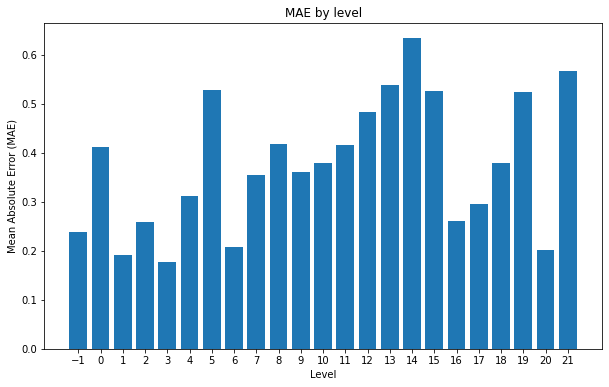

In [75]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [76]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.23
RMSE: 0.48

Round type: round
MSE: 0.25
RMSE: 0.50

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.23
RMSE: 0.48



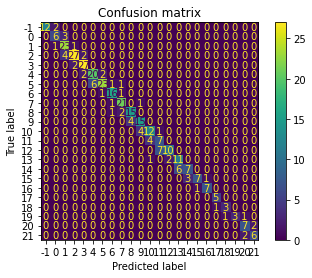

In [77]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [78]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.267273	valid_0's l2: 0.148111


In [79]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.15
RMSE: 0.38
MAE: 0.27


In [81]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

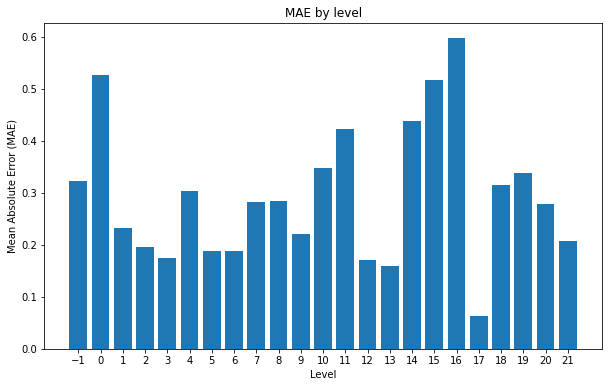

In [82]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test_random_split == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [83]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.15
RMSE: 0.38

Round type: round
MSE: 0.15
RMSE: 0.39

Round type: 0.33
MSE: 0.21
RMSE: 0.45

Round type: 0.45
MSE: 0.17
RMSE: 0.41



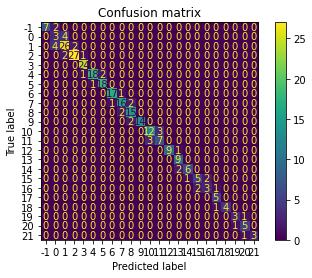

In [84]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [85]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 22:51:14,241] A new study created in memory with name: no-name-5748074f-f7b9-4707-b9be-aae222a0c2d0
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.189029 + 0.0421512


feature_fraction, val_score: 0.187126:   0%|                                                     | 0/7 [00:01<?, ?it/s]

[200]	cv_agg's l2: 0.187439 + 0.0395924
Early stopping, best iteration is:
[129]	cv_agg's l2: 0.187126 + 0.0396375


feature_fraction, val_score: 0.187126:  14%|######4                                      | 1/7 [00:01<00:07,  1.33s/it]

[100]	cv_agg's l2: 0.193604 + 0.044553


feature_fraction, val_score: 0.187126:  29%|############8                                | 2/7 [00:02<00:06,  1.36s/it]

[200]	cv_agg's l2: 0.189449 + 0.0412207
Early stopping, best iteration is:
[129]	cv_agg's l2: 0.187126 + 0.0396375
[100]	cv_agg's l2: 0.197112 + 0.0468621


feature_fraction, val_score: 0.187126:  29%|############8                                | 2/7 [00:03<00:06,  1.36s/it]

[200]	cv_agg's l2: 0.192544 + 0.0436263
Early stopping, best iteration is:
[129]	cv_agg's l2: 0.187126 + 0.0396375


feature_fraction, val_score: 0.187126:  43%|###################2                         | 3/7 [00:03<00:05,  1.32s/it]

[100]	cv_agg's l2: 0.193348 + 0.0492434


feature_fraction, val_score: 0.187126:  57%|#########################7                   | 4/7 [00:05<00:03,  1.33s/it]

[200]	cv_agg's l2: 0.188999 + 0.0455931
Early stopping, best iteration is:
[129]	cv_agg's l2: 0.187126 + 0.0396375


[I 2023-10-28 22:51:19,578] Trial 3 finished with value: 0.1904896139834802 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.18712638687935298.
feature_fraction, val_score: 0.187126:  57%|#########################7                   | 4/7 [00:05<00:03,  1.33s/it]

[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895


feature_fraction, val_score: 0.181620:  71%|################################1            | 5/7 [00:06<00:02,  1.36s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.18162 + 0.039126
[100]	cv_agg's l2: 0.211092 + 0.0319903
[200]	cv_agg's l2: 0.205759 + 0.0279106


feature_fraction, val_score: 0.181620:  86%|######################################5      | 6/7 [00:08<00:01,  1.36s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.18162 + 0.039126
[100]	cv_agg's l2: 0.18438 + 0.0449524
[200]	cv_agg's l2: 0.183193 + 0.0433851


feature_fraction, val_score: 0.181620: 100%|#############################################| 7/7 [00:09<00:00,  1.37s/it]


Early stopping, best iteration is:
[149]	cv_agg's l2: 0.18162 + 0.039126


num_leaves, val_score: 0.181620:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895


num_leaves, val_score: 0.181620:   5%|##5                                               | 1/20 [00:01<00:31,  1.67s/it]

Early stopping, best iteration is:
[149]	cv_agg's l2: 0.18162 + 0.039126
[100]	cv_agg's l2: 0.192627 + 0.0505598
[200]	cv_agg's l2: 0.181594 + 0.0439183
[300]	cv_agg's l2: 0.176702 + 0.0410536
[400]	cv_agg's l2: 0.173965 + 0.0384729
[500]	cv_agg's l2: 0.171684 + 0.036953
[600]	cv_agg's l2: 0.171061 + 0.0358728


num_leaves, val_score: 0.170850:  10%|#####                                             | 2/20 [00:03<00:28,  1.60s/it]

[700]	cv_agg's l2: 0.171371 + 0.0362584
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.17085 + 0.0362369
[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966


num_leaves, val_score: 0.170850:  10%|#####                                             | 2/20 [00:08<00:28,  1.60s/it]

[700]	cv_agg's l2: 0.185235 + 0.0380708
Early stopping, best iteration is:
[629]	cv_agg's l2: 0.17085 + 0.0362369


num_leaves, val_score: 0.170850:  15%|#######5                                          | 3/20 [00:08<00:53,  3.14s/it]

[100]	cv_agg's l2: 0.205388 + 0.0620366
[200]	cv_agg's l2: 0.185795 + 0.0503854
[300]	cv_agg's l2: 0.1798 + 0.0430902
[400]	cv_agg's l2: 0.176543 + 0.0396884
[500]	cv_agg's l2: 0.173627 + 0.0367
[600]	cv_agg's l2: 0.171287 + 0.0353216
[700]	cv_agg's l2: 0.169807 + 0.034365
[800]	cv_agg's l2: 0.168546 + 0.0344482
[900]	cv_agg's l2: 0.168108 + 0.0338656
[1000]	cv_agg's l2: 0.16762 + 0.0331463


num_leaves, val_score: 0.167251:  20%|##########                                        | 4/20 [00:10<00:42,  2.64s/it]

[1100]	cv_agg's l2: 0.168122 + 0.0331992
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.327744 + 0.0525015
[200]	cv_agg's l2: 0.292965 + 0.0414451
[300]	cv_agg's l2: 0.283857 + 0.0383261
[400]	cv_agg's l2: 0.276493 + 0.0374932
[500]	cv_agg's l2: 0.270766 + 0.0372945
[600]	cv_agg's l2: 0.265419 + 0.0371788
[700]	cv_agg's l2: 0.261289 + 0.0373602
[800]	cv_agg's l2: 0.257346 + 0.0374912
[900]	cv_agg's l2: 0.254179 + 0.0377817
[1000]	cv_agg's l2: 0.251216 + 0.0380356


num_leaves, val_score: 0.167251:  25%|############5                                     | 5/20 [00:11<00:32,  2.15s/it]

[1100]	cv_agg's l2: 0.248455 + 0.0379825
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.187793 + 0.046817
[200]	cv_agg's l2: 0.178261 + 0.0392295
[300]	cv_agg's l2: 0.174987 + 0.0378484
[400]	cv_agg's l2: 0.173793 + 0.035851
[500]	cv_agg's l2: 0.173253 + 0.0356467
[600]	cv_agg's l2: 0.173467 + 0.0350041
[700]	cv_agg's l2: 0.174202 + 0.0344424
[800]	cv_agg's l2: 0.174547 + 0.0341659
[900]	cv_agg's l2: 0.174867 + 0.0343892
[1000]	cv_agg's l2: 0.175102 + 0.0345303


num_leaves, val_score: 0.167251:  30%|###############                                   | 6/20 [00:13<00:31,  2.28s/it]

[1100]	cv_agg's l2: 0.175558 + 0.0344279
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176


num_leaves, val_score: 0.167251:  35%|#################5                                | 7/20 [00:20<00:48,  3.73s/it]

Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


num_leaves, val_score: 0.167251:  40%|####################                              | 8/20 [00:27<00:56,  4.74s/it]

[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


num_leaves, val_score: 0.167251:  45%|######################5                           | 9/20 [00:34<00:58,  5.33s/it]

[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183903 + 0.0376662
[600]	cv_agg's l2: 0.184525 + 0.0378974
[700]	cv_agg's l2: 0.185293 + 0.0380685
[800]	cv_agg's l2: 0.185801 + 0.0380518
[900]	cv_agg's l2: 0.186338 + 0.0383844
[1000]	cv_agg's l2: 0.186633 + 0.0384555


num_leaves, val_score: 0.167251:  45%|######################5                           | 9/20 [00:42<00:58,  5.33s/it]

[1100]	cv_agg's l2: 0.187011 + 0.0384067
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


num_leaves, val_score: 0.167251:  50%|########################5                        | 10/20 [00:42<01:02,  6.22s/it]

[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176


num_leaves, val_score: 0.167251:  55%|##########################9                      | 11/20 [00:49<00:58,  6.53s/it]

Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


num_leaves, val_score: 0.167251:  60%|#############################4                   | 12/20 [00:56<00:54,  6.77s/it]

[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


num_leaves, val_score: 0.167251:  65%|###############################8                 | 13/20 [01:03<00:46,  6.68s/it]

[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176


num_leaves, val_score: 0.167251:  70%|##################################3              | 14/20 [01:10<00:40,  6.79s/it]

Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.201446 + 0.0399518
[200]	cv_agg's l2: 0.185779 + 0.0324278
[300]	cv_agg's l2: 0.180464 + 0.0301054
[400]	cv_agg's l2: 0.177665 + 0.0277318
[500]	cv_agg's l2: 0.175998 + 0.0266414
[600]	cv_agg's l2: 0.175108 + 0.0257079
[700]	cv_agg's l2: 0.174697 + 0.0248986
[800]	cv_agg's l2: 0.174892 + 0.025887
[900]	cv_agg's l2: 0.175488 + 0.0266134
[1000]	cv_agg's l2: 0.175168 + 0.0265082


num_leaves, val_score: 0.167251:  75%|####################################7            | 15/20 [01:12<00:26,  5.40s/it]

[1100]	cv_agg's l2: 0.174639 + 0.0265756
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176


num_leaves, val_score: 0.167251:  80%|#######################################2         | 16/20 [01:19<00:23,  5.86s/it]

Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.187951 + 0.0461293
[200]	cv_agg's l2: 0.180446 + 0.0365084
[300]	cv_agg's l2: 0.177545 + 0.0341193
[400]	cv_agg's l2: 0.175921 + 0.0325718
[500]	cv_agg's l2: 0.175763 + 0.0319388
[600]	cv_agg's l2: 0.175749 + 0.0309752
[700]	cv_agg's l2: 0.175578 + 0.0306067
[800]	cv_agg's l2: 0.176227 + 0.0302153
[900]	cv_agg's l2: 0.176076 + 0.0295526
[1000]	cv_agg's l2: 0.176413 + 0.0292116


num_leaves, val_score: 0.167251:  85%|#########################################6       | 17/20 [01:22<00:14,  4.96s/it]

[1100]	cv_agg's l2: 0.176528 + 0.0292666
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


num_leaves, val_score: 0.167251:  90%|############################################1    | 18/20 [01:29<00:11,  5.63s/it]

[100]	cv_agg's l2: 0.183069 + 0.0400372
[200]	cv_agg's l2: 0.182468 + 0.038895
[300]	cv_agg's l2: 0.182662 + 0.038338
[400]	cv_agg's l2: 0.183332 + 0.0376441
[500]	cv_agg's l2: 0.183885 + 0.0376662
[600]	cv_agg's l2: 0.18457 + 0.0378966
[700]	cv_agg's l2: 0.185235 + 0.0380708
[800]	cv_agg's l2: 0.185688 + 0.0380577
[900]	cv_agg's l2: 0.186185 + 0.0383936
[1000]	cv_agg's l2: 0.186488 + 0.0384646
[1100]	cv_agg's l2: 0.186842 + 0.0384176
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


num_leaves, val_score: 0.167251:  95%|##############################################5  | 19/20 [01:36<00:06,  6.14s/it]

[100]	cv_agg's l2: 0.18189 + 0.0420923
[200]	cv_agg's l2: 0.181803 + 0.0408356
[300]	cv_agg's l2: 0.182234 + 0.039627
[400]	cv_agg's l2: 0.183454 + 0.0395822
[500]	cv_agg's l2: 0.184205 + 0.0400321
[600]	cv_agg's l2: 0.185174 + 0.0403093
[700]	cv_agg's l2: 0.185749 + 0.0402157
[800]	cv_agg's l2: 0.186122 + 0.0402053
[900]	cv_agg's l2: 0.186517 + 0.0401429
[1000]	cv_agg's l2: 0.186795 + 0.0401771


num_leaves, val_score: 0.167251:  95%|##############################################5  | 19/20 [01:43<00:06,  6.14s/it]

[1100]	cv_agg's l2: 0.187082 + 0.040255
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


bagging, val_score: 0.167251:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.261027 + 0.0658032
[200]	cv_agg's l2: 0.237117 + 0.0541641
[300]	cv_agg's l2: 0.230864 + 0.0502011
[400]	cv_agg's l2: 0.225895 + 0.0455849
[500]	cv_agg's l2: 0.222065 + 0.0448813
[600]	cv_agg's l2: 0.220556 + 0.0469792
[700]	cv_agg's l2: 0.219082 + 0.0476339
[800]	cv_agg's l2: 0.215951 + 0.0459873
[900]	cv_agg's l2: 0.214241 + 0.0465454
[1000]	cv_agg's l2: 0.210739 + 0.0438845


bagging, val_score: 0.167251:  10%|#####3                                               | 1/10 [00:02<00:20,  2.24s/it]

[1100]	cv_agg's l2: 0.210817 + 0.045138
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.20803 + 0.0550602
[200]	cv_agg's l2: 0.190637 + 0.0416296
[300]	cv_agg's l2: 0.184839 + 0.0367067
[400]	cv_agg's l2: 0.181991 + 0.035122
[500]	cv_agg's l2: 0.180046 + 0.0334517
[600]	cv_agg's l2: 0.178553 + 0.0314633
[700]	cv_agg's l2: 0.177955 + 0.0305813
[800]	cv_agg's l2: 0.176949 + 0.0303955
[900]	cv_agg's l2: 0.176269 + 0.0304043
[1000]	cv_agg's l2: 0.176126 + 0.0310122


bagging, val_score: 0.167251:  20%|##########6                                          | 2/10 [00:04<00:16,  2.06s/it]

[1100]	cv_agg's l2: 0.176573 + 0.0318492
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.235355 + 0.0474685
[200]	cv_agg's l2: 0.209769 + 0.039565
[300]	cv_agg's l2: 0.199393 + 0.0345431
[400]	cv_agg's l2: 0.196482 + 0.034091
[500]	cv_agg's l2: 0.192616 + 0.0299645
[600]	cv_agg's l2: 0.19199 + 0.0311154
[700]	cv_agg's l2: 0.192162 + 0.0319067
[800]	cv_agg's l2: 0.191342 + 0.0308221
[900]	cv_agg's l2: 0.190795 + 0.0303426
[1000]	cv_agg's l2: 0.188103 + 0.0295058
[1100]	cv_agg's l2: 0.187604 + 0.0300225


bagging, val_score: 0.167251:  30%|###############9                                     | 3/10 [00:06<00:14,  2.04s/it]

Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.205388 + 0.0620366
[200]	cv_agg's l2: 0.185795 + 0.0503854
[300]	cv_agg's l2: 0.1798 + 0.0430902
[400]	cv_agg's l2: 0.176543 + 0.0396884
[500]	cv_agg's l2: 0.173627 + 0.0367
[600]	cv_agg's l2: 0.171287 + 0.0353216
[700]	cv_agg's l2: 0.169807 + 0.034365
[800]	cv_agg's l2: 0.168546 + 0.0344482
[900]	cv_agg's l2: 0.168108 + 0.0338656
[1000]	cv_agg's l2: 0.16762 + 0.0331463


bagging, val_score: 0.167251:  40%|#####################2                               | 4/10 [00:08<00:11,  2.00s/it]

[1100]	cv_agg's l2: 0.168122 + 0.0331992
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.21038 + 0.0561985
[200]	cv_agg's l2: 0.190893 + 0.0436455
[300]	cv_agg's l2: 0.182505 + 0.0394673
[400]	cv_agg's l2: 0.178915 + 0.0343745
[500]	cv_agg's l2: 0.177193 + 0.0337205
[600]	cv_agg's l2: 0.176361 + 0.0341629
[700]	cv_agg's l2: 0.175 + 0.0327014
[800]	cv_agg's l2: 0.174283 + 0.0322234
[900]	cv_agg's l2: 0.174358 + 0.0316831
[1000]	cv_agg's l2: 0.173943 + 0.0312587


bagging, val_score: 0.167251:  50%|##########################5                          | 5/10 [00:09<00:09,  1.94s/it]

[1100]	cv_agg's l2: 0.174116 + 0.0315046
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.20952 + 0.053864
[200]	cv_agg's l2: 0.19062 + 0.0443892
[300]	cv_agg's l2: 0.184283 + 0.038998
[400]	cv_agg's l2: 0.181129 + 0.0367525
[500]	cv_agg's l2: 0.17893 + 0.0343611
[600]	cv_agg's l2: 0.176561 + 0.0324012
[700]	cv_agg's l2: 0.176235 + 0.0315242
[800]	cv_agg's l2: 0.176297 + 0.0296647
[900]	cv_agg's l2: 0.17669 + 0.0299101
[1000]	cv_agg's l2: 0.176687 + 0.0305519


bagging, val_score: 0.167251:  60%|###############################8                     | 6/10 [00:11<00:07,  1.90s/it]

[1100]	cv_agg's l2: 0.176496 + 0.0296714
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.21342 + 0.0590701
[200]	cv_agg's l2: 0.194768 + 0.043115
[300]	cv_agg's l2: 0.186574 + 0.0377174
[400]	cv_agg's l2: 0.183071 + 0.0352039
[500]	cv_agg's l2: 0.180376 + 0.0340226
[600]	cv_agg's l2: 0.178261 + 0.0317481
[700]	cv_agg's l2: 0.177592 + 0.0305396
[800]	cv_agg's l2: 0.177407 + 0.0301531
[900]	cv_agg's l2: 0.176923 + 0.0287473
[1000]	cv_agg's l2: 0.176182 + 0.0285556


bagging, val_score: 0.167251:  70%|#####################################                | 7/10 [00:13<00:05,  1.98s/it]

[1100]	cv_agg's l2: 0.175806 + 0.0277283
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.220553 + 0.0470533
[200]	cv_agg's l2: 0.200642 + 0.0389351
[300]	cv_agg's l2: 0.192184 + 0.0361649
[400]	cv_agg's l2: 0.188327 + 0.0333784
[500]	cv_agg's l2: 0.186394 + 0.0300067
[600]	cv_agg's l2: 0.183705 + 0.029835
[700]	cv_agg's l2: 0.18246 + 0.0286993
[800]	cv_agg's l2: 0.18091 + 0.0279355
[900]	cv_agg's l2: 0.180491 + 0.0265165
[1000]	cv_agg's l2: 0.179655 + 0.0274786
[1100]	cv_agg's l2: 0.180539 + 0.0262629


bagging, val_score: 0.167251:  80%|##########################################4          | 8/10 [00:16<00:04,  2.07s/it]

Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.218573 + 0.0368843
[200]	cv_agg's l2: 0.196973 + 0.0328724
[300]	cv_agg's l2: 0.187377 + 0.0269236
[400]	cv_agg's l2: 0.183732 + 0.0255739
[500]	cv_agg's l2: 0.181045 + 0.0244898
[600]	cv_agg's l2: 0.180101 + 0.0226393
[700]	cv_agg's l2: 0.178987 + 0.0228546
[800]	cv_agg's l2: 0.178264 + 0.0217268
[900]	cv_agg's l2: 0.177255 + 0.0199378
[1000]	cv_agg's l2: 0.176571 + 0.0192758


bagging, val_score: 0.167251:  90%|###############################################7     | 9/10 [00:18<00:02,  2.09s/it]

[1100]	cv_agg's l2: 0.176075 + 0.0189344
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.210096 + 0.0506457
[200]	cv_agg's l2: 0.19014 + 0.0397636
[300]	cv_agg's l2: 0.183831 + 0.0361329
[400]	cv_agg's l2: 0.18145 + 0.0360514
[500]	cv_agg's l2: 0.178899 + 0.0322712
[600]	cv_agg's l2: 0.17712 + 0.0313401
[700]	cv_agg's l2: 0.175563 + 0.0310708
[800]	cv_agg's l2: 0.174438 + 0.0291295
[900]	cv_agg's l2: 0.173725 + 0.0276192
[1000]	cv_agg's l2: 0.173747 + 0.0274682


bagging, val_score: 0.167251: 100%|####################################################| 10/10 [00:20<00:00,  2.04s/it]


[1100]	cv_agg's l2: 0.17443 + 0.0274835
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


feature_fraction_stage2, val_score: 0.167251:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.212557 + 0.0602036
[200]	cv_agg's l2: 0.191632 + 0.0472127
[300]	cv_agg's l2: 0.183863 + 0.0418065
[400]	cv_agg's l2: 0.180232 + 0.0386791
[500]	cv_agg's l2: 0.177575 + 0.036716
[600]	cv_agg's l2: 0.175732 + 0.0353622
[700]	cv_agg's l2: 0.1744 + 0.0345266
[800]	cv_agg's l2: 0.173786 + 0.0341679
[900]	cv_agg's l2: 0.172162 + 0.034433
[1000]	cv_agg's l2: 0.171775 + 0.0341268


feature_fraction_stage2, val_score: 0.167251:  17%|######3                               | 1/6 [00:01<00:09,  1.86s/it]

[1100]	cv_agg's l2: 0.172192 + 0.0347017
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.213128 + 0.0446233
[200]	cv_agg's l2: 0.190653 + 0.0375812
[300]	cv_agg's l2: 0.182898 + 0.0362424
[400]	cv_agg's l2: 0.180243 + 0.0339547
[500]	cv_agg's l2: 0.178802 + 0.0325069
[600]	cv_agg's l2: 0.177964 + 0.0323996
[700]	cv_agg's l2: 0.177901 + 0.0322311
[800]	cv_agg's l2: 0.177161 + 0.0321238
[900]	cv_agg's l2: 0.176442 + 0.0320728
[1000]	cv_agg's l2: 0.17617 + 0.0326993


feature_fraction_stage2, val_score: 0.167251:  33%|############6                         | 2/6 [00:03<00:07,  1.92s/it]

[1100]	cv_agg's l2: 0.176153 + 0.0321232
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.269686 + 0.032694
[200]	cv_agg's l2: 0.22587 + 0.0212418
[300]	cv_agg's l2: 0.210709 + 0.0185996
[400]	cv_agg's l2: 0.201351 + 0.0152996
[500]	cv_agg's l2: 0.196374 + 0.0147038
[600]	cv_agg's l2: 0.191676 + 0.0141476
[700]	cv_agg's l2: 0.189608 + 0.0140824
[800]	cv_agg's l2: 0.187698 + 0.0137798
[900]	cv_agg's l2: 0.187219 + 0.0137569
[1000]	cv_agg's l2: 0.185915 + 0.0131442


feature_fraction_stage2, val_score: 0.167251:  50%|###################                   | 3/6 [00:05<00:05,  1.87s/it]

[1100]	cv_agg's l2: 0.185189 + 0.0136536
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.213128 + 0.0446233
[200]	cv_agg's l2: 0.190653 + 0.0375812
[300]	cv_agg's l2: 0.182898 + 0.0362424
[400]	cv_agg's l2: 0.180243 + 0.0339547
[500]	cv_agg's l2: 0.178802 + 0.0325069
[600]	cv_agg's l2: 0.177964 + 0.0323996
[700]	cv_agg's l2: 0.177901 + 0.0322311
[800]	cv_agg's l2: 0.177161 + 0.0321238
[900]	cv_agg's l2: 0.176442 + 0.0320728
[1000]	cv_agg's l2: 0.17617 + 0.0326993


feature_fraction_stage2, val_score: 0.167251:  67%|#########################3            | 4/6 [00:07<00:03,  1.87s/it]

[1100]	cv_agg's l2: 0.176153 + 0.0321232
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.205388 + 0.0620366
[200]	cv_agg's l2: 0.185795 + 0.0503854
[300]	cv_agg's l2: 0.1798 + 0.0430902
[400]	cv_agg's l2: 0.176543 + 0.0396884
[500]	cv_agg's l2: 0.173627 + 0.0367
[600]	cv_agg's l2: 0.171287 + 0.0353216
[700]	cv_agg's l2: 0.169807 + 0.034365
[800]	cv_agg's l2: 0.168546 + 0.0344482
[900]	cv_agg's l2: 0.168108 + 0.0338656
[1000]	cv_agg's l2: 0.16762 + 0.0331463


feature_fraction_stage2, val_score: 0.167251:  83%|###############################6      | 5/6 [00:09<00:01,  1.88s/it]

[1100]	cv_agg's l2: 0.168122 + 0.0331992
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.205388 + 0.0620366
[200]	cv_agg's l2: 0.185795 + 0.0503854
[300]	cv_agg's l2: 0.1798 + 0.0430902
[400]	cv_agg's l2: 0.176543 + 0.0396884
[500]	cv_agg's l2: 0.173627 + 0.0367
[600]	cv_agg's l2: 0.171287 + 0.0353216
[700]	cv_agg's l2: 0.169807 + 0.034365
[800]	cv_agg's l2: 0.168546 + 0.0344482
[900]	cv_agg's l2: 0.168108 + 0.0338656
[1000]	cv_agg's l2: 0.16762 + 0.0331463


feature_fraction_stage2, val_score: 0.167251: 100%|######################################| 6/6 [00:11<00:00,  1.86s/it]


[1100]	cv_agg's l2: 0.168122 + 0.0331992
Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139


regularization_factors, val_score: 0.167251:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.207002 + 0.0642934
[200]	cv_agg's l2: 0.186727 + 0.0506166
[300]	cv_agg's l2: 0.180275 + 0.0450821
[400]	cv_agg's l2: 0.176958 + 0.0404708
[500]	cv_agg's l2: 0.173316 + 0.0390793
[600]	cv_agg's l2: 0.171334 + 0.0376579
[700]	cv_agg's l2: 0.17121 + 0.0369463
[800]	cv_agg's l2: 0.171537 + 0.036773
[900]	cv_agg's l2: 0.171042 + 0.0364114
[1000]	cv_agg's l2: 0.170697 + 0.0356335
[1100]	cv_agg's l2: 0.17063 + 0.0356754


regularization_factors, val_score: 0.167251:   5%|#9                                    | 1/20 [00:02<00:38,  2.00s/it]

Early stopping, best iteration is:
[1034]	cv_agg's l2: 0.167251 + 0.0327139
[100]	cv_agg's l2: 0.206414 + 0.0642318
[200]	cv_agg's l2: 0.185236 + 0.0516313
[300]	cv_agg's l2: 0.17804 + 0.0430976
[400]	cv_agg's l2: 0.174574 + 0.0403192
[500]	cv_agg's l2: 0.171864 + 0.0376923
[600]	cv_agg's l2: 0.169625 + 0.0358499
[700]	cv_agg's l2: 0.167862 + 0.0352013
[800]	cv_agg's l2: 0.166794 + 0.0342626


regularization_factors, val_score: 0.166391:  10%|###8                                  | 2/20 [00:03<00:30,  1.68s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.250283 + 0.0641952
[200]	cv_agg's l2: 0.237441 + 0.0637465
[300]	cv_agg's l2: 0.236717 + 0.0639175
[400]	cv_agg's l2: 0.236716 + 0.0639179
[500]	cv_agg's l2: 0.236716 + 0.0639179
[600]	cv_agg's l2: 0.236716 + 0.0639179
[700]	cv_agg's l2: 0.236716 + 0.0639179
[800]	cv_agg's l2: 0.236716 + 0.0639179


regularization_factors, val_score: 0.166391:  15%|#####7                                | 3/20 [00:04<00:23,  1.40s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.214066 + 0.0522895
[200]	cv_agg's l2: 0.192283 + 0.0439268
[300]	cv_agg's l2: 0.184251 + 0.0406744
[400]	cv_agg's l2: 0.180763 + 0.038911
[500]	cv_agg's l2: 0.178854 + 0.036897
[600]	cv_agg's l2: 0.176693 + 0.0341851
[700]	cv_agg's l2: 0.175582 + 0.0336026


regularization_factors, val_score: 0.166391:  20%|#######6                              | 4/20 [00:05<00:22,  1.41s/it]

[800]	cv_agg's l2: 0.17472 + 0.0331275
Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205389 + 0.0620374
[200]	cv_agg's l2: 0.185595 + 0.0505669
[300]	cv_agg's l2: 0.179213 + 0.0423383
[400]	cv_agg's l2: 0.175683 + 0.0387863
[500]	cv_agg's l2: 0.172522 + 0.0366311
[600]	cv_agg's l2: 0.170453 + 0.0361282
[700]	cv_agg's l2: 0.169423 + 0.036502
[800]	cv_agg's l2: 0.168474 + 0.0355105


regularization_factors, val_score: 0.166391:  25%|#########5                            | 5/20 [00:07<00:21,  1.43s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205388 + 0.0620366
[200]	cv_agg's l2: 0.185795 + 0.0503854
[300]	cv_agg's l2: 0.1798 + 0.0430902
[400]	cv_agg's l2: 0.176543 + 0.0396884
[500]	cv_agg's l2: 0.173627 + 0.0367
[600]	cv_agg's l2: 0.171287 + 0.0353216
[700]	cv_agg's l2: 0.169807 + 0.034365


regularization_factors, val_score: 0.166391:  30%|###########4                          | 6/20 [00:08<00:19,  1.42s/it]

[800]	cv_agg's l2: 0.168546 + 0.0344482
Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.210465 + 0.0618282
[200]	cv_agg's l2: 0.189462 + 0.0485468
[300]	cv_agg's l2: 0.181466 + 0.0426339
[400]	cv_agg's l2: 0.178313 + 0.0406281
[500]	cv_agg's l2: 0.173958 + 0.0378716
[600]	cv_agg's l2: 0.17201 + 0.0376884
[700]	cv_agg's l2: 0.171174 + 0.0362226
[800]	cv_agg's l2: 0.170027 + 0.0343782


regularization_factors, val_score: 0.166391:  35%|#############3                        | 7/20 [00:10<00:19,  1.47s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.236999 + 0.065004
[200]	cv_agg's l2: 0.22305 + 0.0626357
[300]	cv_agg's l2: 0.221402 + 0.0631866
[400]	cv_agg's l2: 0.2214 + 0.0631875
[500]	cv_agg's l2: 0.2214 + 0.0631875
[600]	cv_agg's l2: 0.2214 + 0.0631875
[700]	cv_agg's l2: 0.2214 + 0.0631875


regularization_factors, val_score: 0.166391:  40%|###############2                      | 8/20 [00:11<00:16,  1.39s/it]

[800]	cv_agg's l2: 0.2214 + 0.0631875
Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205388 + 0.0620369
[200]	cv_agg's l2: 0.185594 + 0.050566
[300]	cv_agg's l2: 0.179338 + 0.0422943
[400]	cv_agg's l2: 0.175886 + 0.0390397
[500]	cv_agg's l2: 0.172639 + 0.0368858
[600]	cv_agg's l2: 0.170521 + 0.036381
[700]	cv_agg's l2: 0.169564 + 0.0363815
[800]	cv_agg's l2: 0.168579 + 0.0348616


regularization_factors, val_score: 0.166391:  45%|#################1                    | 9/20 [00:13<00:16,  1.51s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205388 + 0.062037
[200]	cv_agg's l2: 0.185595 + 0.0505662
[300]	cv_agg's l2: 0.179338 + 0.0422946
[400]	cv_agg's l2: 0.175886 + 0.0390401
[500]	cv_agg's l2: 0.172647 + 0.0368829
[600]	cv_agg's l2: 0.170694 + 0.0363062
[700]	cv_agg's l2: 0.169799 + 0.036278
[800]	cv_agg's l2: 0.168412 + 0.0349567


regularization_factors, val_score: 0.166391:  50%|##################5                  | 10/20 [00:14<00:15,  1.51s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.21037 + 0.0620941
[200]	cv_agg's l2: 0.189166 + 0.0491805
[300]	cv_agg's l2: 0.181823 + 0.0440739
[400]	cv_agg's l2: 0.17675 + 0.0409515
[500]	cv_agg's l2: 0.174007 + 0.0396165
[600]	cv_agg's l2: 0.171286 + 0.0371205
[700]	cv_agg's l2: 0.170654 + 0.035843
[800]	cv_agg's l2: 0.169977 + 0.035555


regularization_factors, val_score: 0.166391:  55%|####################3                | 11/20 [00:16<00:13,  1.52s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205388 + 0.0620366
[200]	cv_agg's l2: 0.185795 + 0.0503855
[300]	cv_agg's l2: 0.1798 + 0.0430902
[400]	cv_agg's l2: 0.17652 + 0.0397105
[500]	cv_agg's l2: 0.173694 + 0.0365401
[600]	cv_agg's l2: 0.171566 + 0.0349831
[700]	cv_agg's l2: 0.170475 + 0.0337514
[800]	cv_agg's l2: 0.169646 + 0.03357


regularization_factors, val_score: 0.166391:  60%|######################2              | 12/20 [00:17<00:11,  1.49s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205395 + 0.062042
[200]	cv_agg's l2: 0.185735 + 0.0504627
[300]	cv_agg's l2: 0.178586 + 0.0432511
[400]	cv_agg's l2: 0.175559 + 0.0390039
[500]	cv_agg's l2: 0.173899 + 0.0379579
[600]	cv_agg's l2: 0.172314 + 0.0368249
[700]	cv_agg's l2: 0.171843 + 0.0371735


regularization_factors, val_score: 0.166391:  65%|########################             | 13/20 [00:19<00:10,  1.50s/it]

[800]	cv_agg's l2: 0.170966 + 0.0369241
Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.212305 + 0.0600711
[200]	cv_agg's l2: 0.193284 + 0.0476989
[300]	cv_agg's l2: 0.18479 + 0.0420507
[400]	cv_agg's l2: 0.181022 + 0.0388098
[500]	cv_agg's l2: 0.178308 + 0.0378687
[600]	cv_agg's l2: 0.17664 + 0.035024
[700]	cv_agg's l2: 0.174448 + 0.0332081


regularization_factors, val_score: 0.166391:  70%|#########################9           | 14/20 [00:20<00:09,  1.53s/it]

[800]	cv_agg's l2: 0.173632 + 0.0323374
Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205388 + 0.0620366
[200]	cv_agg's l2: 0.185795 + 0.0503855
[300]	cv_agg's l2: 0.1798 + 0.0430902
[400]	cv_agg's l2: 0.17652 + 0.0397105
[500]	cv_agg's l2: 0.173694 + 0.0365401
[600]	cv_agg's l2: 0.171566 + 0.034983
[700]	cv_agg's l2: 0.170475 + 0.0337514
[800]	cv_agg's l2: 0.169646 + 0.03357


regularization_factors, val_score: 0.166391:  75%|###########################7         | 15/20 [00:22<00:07,  1.54s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.20539 + 0.0620385
[200]	cv_agg's l2: 0.185597 + 0.0505688
[300]	cv_agg's l2: 0.179068 + 0.042928
[400]	cv_agg's l2: 0.175928 + 0.0393719
[500]	cv_agg's l2: 0.173919 + 0.0373684
[600]	cv_agg's l2: 0.172235 + 0.0366286
[700]	cv_agg's l2: 0.170845 + 0.0355106
[800]	cv_agg's l2: 0.170124 + 0.0348436


regularization_factors, val_score: 0.166391:  80%|#############################6       | 16/20 [00:24<00:06,  1.57s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.212302 + 0.0620512
[200]	cv_agg's l2: 0.191271 + 0.0475519
[300]	cv_agg's l2: 0.182893 + 0.0445204
[400]	cv_agg's l2: 0.179542 + 0.0407484
[500]	cv_agg's l2: 0.177183 + 0.039646
[600]	cv_agg's l2: 0.175618 + 0.0378125
[700]	cv_agg's l2: 0.173449 + 0.0367001


regularization_factors, val_score: 0.166391:  85%|###############################4     | 17/20 [00:25<00:04,  1.55s/it]

[800]	cv_agg's l2: 0.172335 + 0.0359935
Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205389 + 0.0620377
[200]	cv_agg's l2: 0.185596 + 0.0505674
[300]	cv_agg's l2: 0.179213 + 0.0423391
[400]	cv_agg's l2: 0.175683 + 0.0387873
[500]	cv_agg's l2: 0.172522 + 0.0366321
[600]	cv_agg's l2: 0.170453 + 0.036129
[700]	cv_agg's l2: 0.16952 + 0.0365343
[800]	cv_agg's l2: 0.168999 + 0.0364297


regularization_factors, val_score: 0.166391:  90%|#################################3   | 18/20 [00:27<00:03,  1.51s/it]

Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.205388 + 0.0620368
[200]	cv_agg's l2: 0.185795 + 0.0503857
[300]	cv_agg's l2: 0.1798 + 0.0430906
[400]	cv_agg's l2: 0.17652 + 0.0397109
[500]	cv_agg's l2: 0.173807 + 0.0367432
[600]	cv_agg's l2: 0.172336 + 0.0363732
[700]	cv_agg's l2: 0.171059 + 0.0348127


regularization_factors, val_score: 0.166391:  95%|###################################1 | 19/20 [00:28<00:01,  1.49s/it]

[800]	cv_agg's l2: 0.170224 + 0.0346175
Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343
[100]	cv_agg's l2: 0.206035 + 0.0632196
[200]	cv_agg's l2: 0.186692 + 0.0522083
[300]	cv_agg's l2: 0.179615 + 0.0451378
[400]	cv_agg's l2: 0.176715 + 0.0411403
[500]	cv_agg's l2: 0.173916 + 0.0379891
[600]	cv_agg's l2: 0.172235 + 0.036681
[700]	cv_agg's l2: 0.171335 + 0.0361819
[800]	cv_agg's l2: 0.170735 + 0.0367243


regularization_factors, val_score: 0.166391: 100%|#####################################| 20/20 [00:29<00:00,  1.50s/it]


Early stopping, best iteration is:
[780]	cv_agg's l2: 0.166391 + 0.0341343


min_data_in_leaf, val_score: 0.166391:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.197163 + 0.0597941
[200]	cv_agg's l2: 0.171497 + 0.0457868
[300]	cv_agg's l2: 0.161101 + 0.0368793
[400]	cv_agg's l2: 0.156937 + 0.0306542
[500]	cv_agg's l2: 0.155196 + 0.0281465
[600]	cv_agg's l2: 0.152282 + 0.026341
[700]	cv_agg's l2: 0.151238 + 0.0249805
[800]	cv_agg's l2: 0.150081 + 0.0236185
[900]	cv_agg's l2: 0.149314 + 0.0220663
[1000]	cv_agg's l2: 0.148801 + 0.020353
[1100]	cv_agg's l2: 0.148665 + 0.0186578
[1200]	cv_agg's l2: 0.148831 + 0.0186399
Early stopping, best iteration is:
[1140]	cv_agg's l2: 0.148345 + 0.0186142


min_data_in_leaf, val_score: 0.148345:  20%|#########                                    | 1/5 [00:01<00:07,  1.99s/it]

[100]	cv_agg's l2: 0.274695 + 0.0694262
[200]	cv_agg's l2: 0.254202 + 0.055922
[300]	cv_agg's l2: 0.244324 + 0.0521014
[400]	cv_agg's l2: 0.239522 + 0.0503075
[500]	cv_agg's l2: 0.235974 + 0.0472691
[600]	cv_agg's l2: 0.232733 + 0.0465403
[700]	cv_agg's l2: 0.230606 + 0.0456431
[800]	cv_agg's l2: 0.229175 + 0.0449609
[900]	cv_agg's l2: 0.227068 + 0.0439373
[1000]	cv_agg's l2: 0.225742 + 0.0436813
[1100]	cv_agg's l2: 0.224245 + 0.0424865
[1200]	cv_agg's l2: 0.223446 + 0.04299


min_data_in_leaf, val_score: 0.148345:  40%|##################                           | 2/5 [00:04<00:06,  2.03s/it]

Early stopping, best iteration is:
[1140]	cv_agg's l2: 0.148345 + 0.0186142
[100]	cv_agg's l2: 0.69845 + 0.0858651
[200]	cv_agg's l2: 0.659824 + 0.0818525
[300]	cv_agg's l2: 0.637792 + 0.0812847
[400]	cv_agg's l2: 0.62378 + 0.0814631
[500]	cv_agg's l2: 0.614513 + 0.0825368
[600]	cv_agg's l2: 0.607649 + 0.084935
[700]	cv_agg's l2: 0.604873 + 0.0862937
[800]	cv_agg's l2: 0.600369 + 0.0862994
[900]	cv_agg's l2: 0.597609 + 0.0874323
[1000]	cv_agg's l2: 0.596649 + 0.0881717
[1100]	cv_agg's l2: 0.596256 + 0.088212


min_data_in_leaf, val_score: 0.148345:  60%|###########################                  | 3/5 [00:06<00:04,  2.04s/it]

[1200]	cv_agg's l2: 0.595463 + 0.0878631
Early stopping, best iteration is:
[1140]	cv_agg's l2: 0.148345 + 0.0186142
[100]	cv_agg's l2: 0.196981 + 0.0599108
[200]	cv_agg's l2: 0.174611 + 0.0479616
[300]	cv_agg's l2: 0.166702 + 0.0409128
[400]	cv_agg's l2: 0.161473 + 0.0339702
[500]	cv_agg's l2: 0.158573 + 0.0307509
[600]	cv_agg's l2: 0.156234 + 0.0294546
[700]	cv_agg's l2: 0.154227 + 0.02784
[800]	cv_agg's l2: 0.15301 + 0.0264472
[900]	cv_agg's l2: 0.151728 + 0.0253485
[1000]	cv_agg's l2: 0.150704 + 0.0243224
[1100]	cv_agg's l2: 0.150217 + 0.0237227
[1200]	cv_agg's l2: 0.150598 + 0.023096


min_data_in_leaf, val_score: 0.148345:  80%|####################################         | 4/5 [00:08<00:02,  2.02s/it]

Early stopping, best iteration is:
[1140]	cv_agg's l2: 0.148345 + 0.0186142
[100]	cv_agg's l2: 0.218603 + 0.0614588
[200]	cv_agg's l2: 0.197564 + 0.0502475
[300]	cv_agg's l2: 0.191805 + 0.0453317
[400]	cv_agg's l2: 0.188918 + 0.0427126
[500]	cv_agg's l2: 0.185052 + 0.0403489
[600]	cv_agg's l2: 0.182457 + 0.0389302
[700]	cv_agg's l2: 0.180556 + 0.0382583
[800]	cv_agg's l2: 0.179928 + 0.0376861
[900]	cv_agg's l2: 0.179052 + 0.0359408
[1000]	cv_agg's l2: 0.178745 + 0.0356359
[1100]	cv_agg's l2: 0.178734 + 0.0359826
[1200]	cv_agg's l2: 0.178947 + 0.0359476


min_data_in_leaf, val_score: 0.148345: 100%|#############################################| 5/5 [00:10<00:00,  2.06s/it]

Early stopping, best iteration is:
[1140]	cv_agg's l2: 0.148345 + 0.0186142


In [86]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14834492685221662
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.03614293377106285
    lambda_l2: 1.3169595758136168e-08
    num_leaves: 4
    feature_fraction: 0.5
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [87]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [88]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.02
RMSE test: 0.37
MSE test: 0.14
MAE test: 0.25



In [89]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

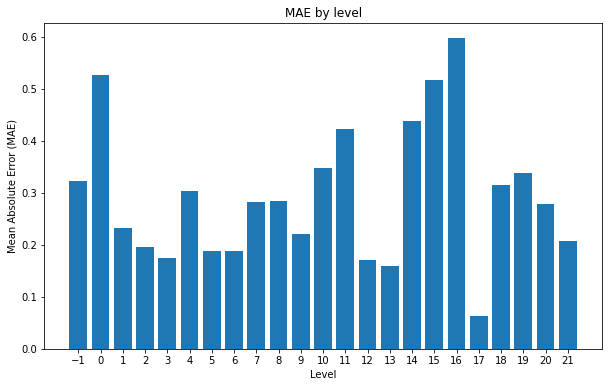

In [90]:
import matplotlib.pyplot as plt

y_test_random_split = y_test_random_split.reset_index(drop=True)
level_max = y_test_random_split.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test_random_split[y_test_random_split == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test_random_split == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [91]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.05
RMSE: 0.23

Round type: round
MSE: 0.08
RMSE: 0.28

Round type: 0.33
MSE: 0.07
RMSE: 0.26

Round type: 0.45
MSE: 0.07
RMSE: 0.27



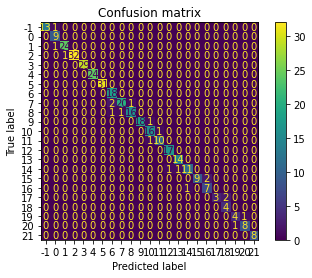

In [92]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [93]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,13,0.260893,0.510777,0.357209
1,chronological,Optuna,13,0.226251,0.475659,0.343464
2,random,normal,13,0.148111,0.384853,0.267273
3,random,Optuna,13,0.136451,0.369393,0.248118


In [94]:
from training.results import plot_summary

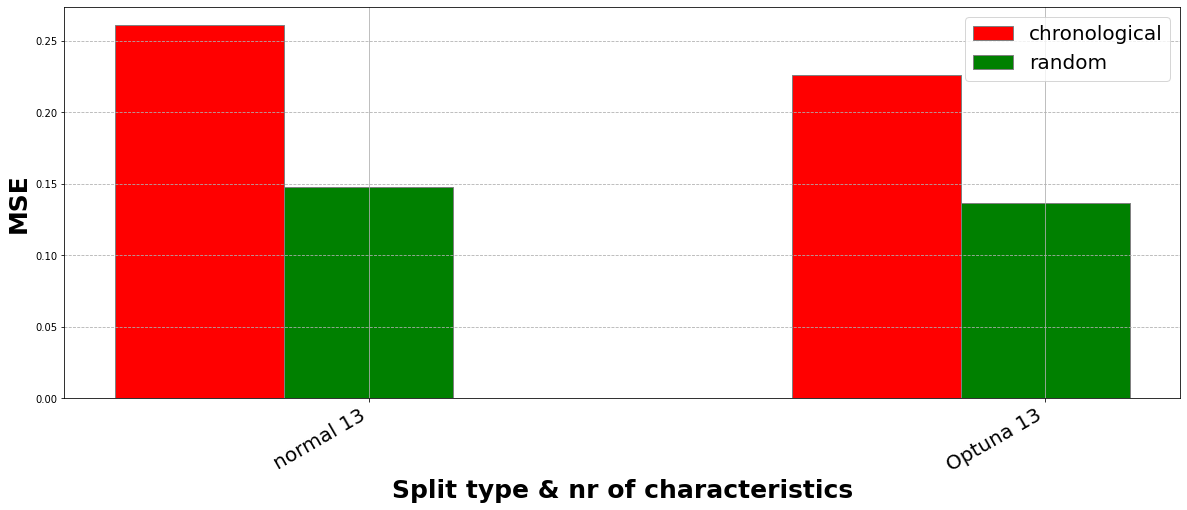

In [95]:
plot_summary(results, "MSE")

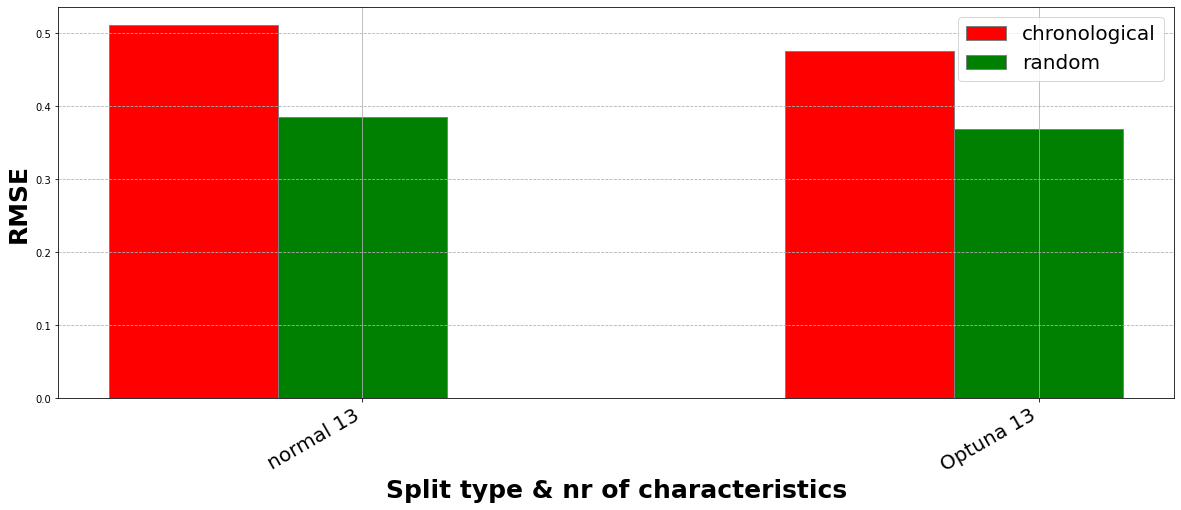

In [96]:
plot_summary(results, "RMSE")

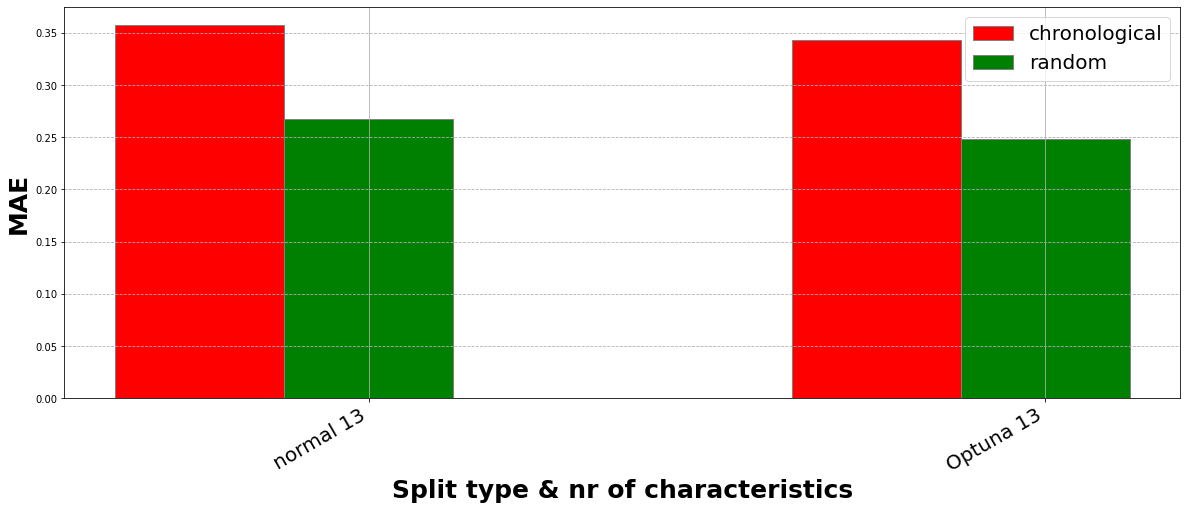

In [97]:
plot_summary(results, "MAE")

In [98]:
results.to_json("./lightgbm_second_results.json")